# Preparing a simple FNN 

In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np

2025-08-05 16:30:04.556848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 16:30:04.619146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754425804.652873 2784256 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754425804.663999 2784256 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754425804.723583 2784256 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Processing
1. Import data and collate them as numpy array

In [3]:
# define this! The rest can remain untouched
molecule = 'water'
n_atoms = 3

In [4]:
data_dir = Path(f'./{molecule}_energies_noise')
model_dir = Path(f'./models/{molecule}_models')
model_dir.mkdir(exist_ok=True, parents=True)

X = []
Y = []
for file_path in data_dir.glob('*.npz'):
    data_file = np.load(file_path)
    try:
        X.append(data_file['coords'])
        Y.append(data_file['energy'])
    except KeyError:
        raise KeyError('wrong key for npz file!')
# you must perform stacking, cannot just convert to array    
X = np.stack(X)
Y = np.stack(Y)
print(X.shape)
print(Y.shape)

(1000, 3, 3)
(1000,)


In [5]:
def hartree_to_kcal_per_mol(Y):
    return Y * 627.50961

Y = hartree_to_kcal_per_mol(Y)

2. split them and prepare them as tf input

In [6]:
x_train, x_valtest, y_train, y_valtest = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(700, 3, 3) (700,)
(201, 3, 3) (201,)
(99, 3, 3) (99,)


3. Prepare dataset, batching and shuffle

In [7]:
# convert to tensor
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset =tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32

# shuffle
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

2025-08-05 16:30:13.574410: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
print(y_test.std())

2.5911027617920146


## Define CNN model

In [9]:
def train(train_dataset, val_dataset, n_atoms, epochs=1000):
    '''
    Simple model:
    1. Input: flatten
    2. Hidden: 1 Dense layer, shape = 64, relu activation
    3. Output: Dense
    '''
    # 
    # model = tf.keras.Sequential([
    #     tf.keras.layers.Flatten(input_shape=(3,3)),
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dense(1)
    # ])

    # initialiser is important for regression task! without it, the whole trend is shifted upwards.
    y_mean = y_train.mean() # not a data leak, if you compute on training dataset only
    const_init = tf.keras.initializers.Constant(y_mean)
    he_init = tf.keras.initializers.HeNormal()
    randnorm_init = tf.keras.initializers.RandomNormal(stddev=0.05)

    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((n_atoms, 3, 1), input_shape=(n_atoms, 3)),      # Add channel dim
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer=he_init, bias_initializer='zeros'),       # 32 filters, 2x2 kernel
        # tf.keras.layers.MaxPooling2D(strides=2), # pooling didnt help.
        # tf.keras.layers.Flatten(), # try: replace  flatten with a global average pooling 2D
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros'),
        tf.keras.layers.Dense(1, kernel_initializer=randnorm_init, bias_initializer=const_init)                                     # Regression output
    ])

    # model = tf.keras.Sequential([
    #     # 1) Keep your reshape
    #     tf.keras.layers.Reshape((3, 3, 1), input_shape=(3, 3)),

    #     # 2) First conv block
    #     tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same'),
    #     tf.keras.layers.BatchNormalization(),           # normalize feature maps
    #     tf.keras.layers.Dropout(0.1),                   # small dropout

    #     # 3) Second conv block
    #     tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
    #     tf.keras.layers.BatchNormalization(),
    #     # No pooling—our “image” is tiny, so we just let GlobalAvgPool handle it

    #     # 4) Global pooling instead of flatten
    #     tf.keras.layers.GlobalAveragePooling2D(),        

    #     # 5) Dense head
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dropout(0.2),

    #     # 6) Final regression output
    #     tf.keras.layers.Dense(1)
    # ])
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=0)
    return model, history.history

### CNN model Training

In [10]:
cnn_model, history = train(train_dataset, val_dataset, n_atoms=n_atoms, epochs=1000)

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Plot loss curve

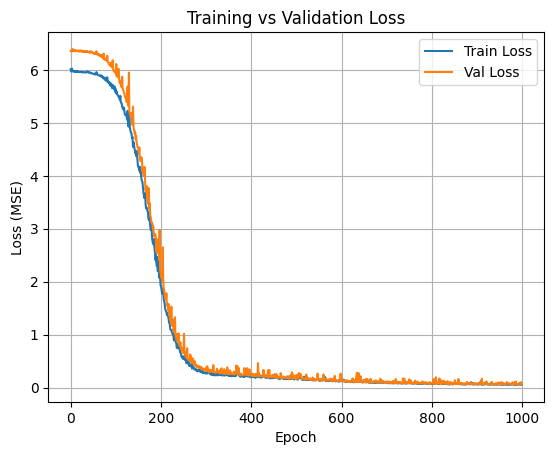

In [11]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### CNN model Evaluation

In [12]:
test_loss = cnn_model.evaluate(test_dataset)
print(f"Test MSE loss: {test_loss:.5f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0541


Test MSE loss: 0.05406


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2025-08-05 16:31:33.674764: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


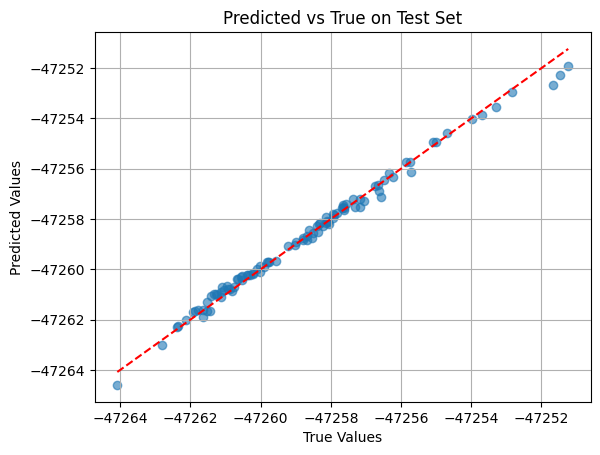

In [13]:
y_pred = cnn_model.predict(test_dataset).flatten()
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect prediction line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MAE: 1.682758e-01
R²:  0.9919


In [15]:

cnn_model.save(model_dir / f'{molecule}_cnn_model.keras')

## Build a simple GNN
Yep everything is kinda copies from ChatGPT...

1. Re-preprocess X, Y (numpy arrays) into graph data with specktral

In [16]:
import numpy as np
import tensorflow as tf

from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader


def build_adjacency_from_xyz(coords, threshold=2.0):
    """
    Given coords: (n_atoms, 3), returns (n_atoms, n_atoms) adjacency matrix
    with 1s where Euclidean distance < threshold and 0 elsewhere (excluding self-loops)
    """
    n = coords.shape[0]
    dists = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    A = (dists < threshold).astype('float32')
    np.fill_diagonal(A, 0.0)  # remove self-loops
    return A

class XYZGraphDataset(Dataset):
    def __init__(self, X, Y, threshold=2.0,  **kwargs):
        self.X = X.astype('float32')         # (N, n_atoms, 3)
        self.Y = Y.astype('float32')         # (N,)
        self.threshold = threshold
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for x, y in zip(self.X, self.Y):
            A = build_adjacency_from_xyz(x, threshold=self.threshold)  # shape (n_atoms, n_atoms)
            graphs.append(Graph(x, a=A, y=np.array([y])))
        return graphs

In [17]:
from spektral.layers import GraphSageConv, GlobalSumPool
'''
tried: GCNConv (only accepts [x,a], cannot accept disjoint batches
GCSConv (shape mismatch)
GINConv (tf error)
GraphSageConv + disable XLA flag + operate on CPU (forced). Both must be present for it work somehow.
'''

class GNNModel(tf.keras.Model):
    def __init__(self, y_mean):
        super().__init__()
        he_init = tf.keras.initializers.HeNormal()

        # ReLU and GeLU layers are best with HeNormal. Default is GlorotUniform, which isn't the most ideal
        self.conv1 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros') 
        self.conv2 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros')
        self.pool = GlobalSumPool()
        self.dense = tf.keras.layers.Dense(1, 
                                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),
                                           bias_initializer=tf.keras.initializers.Constant(y_mean))

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.pool([x, i])
        return self.dense(x)



2. Define model

In [18]:
def train_GNN(x_train, y_train,
              x_val, y_val, 
              epochs=10, batch_size=32, threshold=2.0, verbose=0):
    # Create dataset
    train_dataset = XYZGraphDataset(x_train, y_train, threshold=threshold)

    # tried: SingleLoader (not compatible with N,3,3 data)
    train_loader = DisjointLoader(train_dataset, epochs=epochs, batch_size=batch_size, shuffle=True)

    val_dataset = XYZGraphDataset(x_val, y_val, threshold=threshold)
    val_loader = DisjointLoader(val_dataset, epochs=epochs, batch_size=batch_size, shuffle=False)
    
    # # Build and compile model
    # with tf.device('/CPU:0'):
    model = GNNModel(y_mean=y_train.mean())
    model.compile(optimizer='adam', loss='mse')


    # Train
    history = model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, 
                        validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
                        epochs=epochs, verbose=verbose)    
    
    return model, history.history


3. Train

In [19]:
gnn_model, history = train_GNN(x_train=x_train,y_train=y_train,
                           x_val=x_val,y_val=y_val,
                           epochs=1000)


/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'XYZGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
2025-08-05 16:32:52.135376: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-08-05 16:32:52.292644: I tensorflow/core/framework/local_rendezvous

In [20]:
gnn_model.save(model_dir / f'{molecule}_gnn_model.keras')

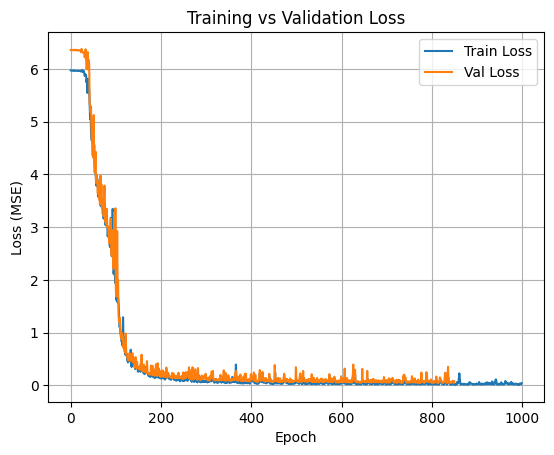

In [21]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(x_test.shape, y_test.shape)

(99, 3, 3) (99,)


In [23]:
# Create test dataset and loader
test_dataset = XYZGraphDataset(x_test, y_test, threshold=2.0)
test_loader = DisjointLoader(test_dataset, epochs=1, batch_size=32, shuffle=False)

# Evaluate on test set
test_loss = gnn_model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print(f"Test MSE loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1098 
Test MSE loss: 0.11


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
y_pred shape: (99,)


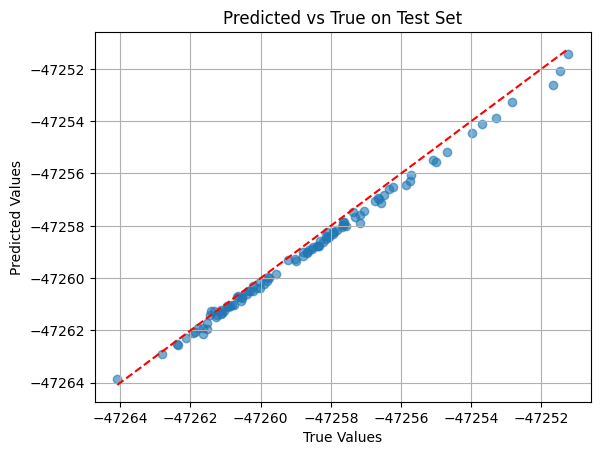

In [24]:
# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = gnn_model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()



In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MAE: 2.957205e-01
R²:  0.9836


## Test on Translational, rotational, permutational invariance

In [26]:
# Evaluation on: CNN, GNN. We have x_test, y_test
from numpy.random import default_rng

def translation(X, offset=10.0):
    '''
    Offset: a (3,) vector (tuple) or a scaler. 
    '''
    off = np.asarray(offset)
    if off.ndim == 0:
        off = np.array([off, off, off])
    return X + off  # broadcasting: (N,n_atoms,3) + (3,) → (N,n_atoms,3)

def rotate_180_y_axis(X):
    R = np.array([[-1, 0, 0],
              [ 0, 1, 0],
              [ 0, 0,-1]])
    return X @ R.T

def permutation(X, seed=None):
    N, n_atoms, xyz = X.shape
    rng = default_rng(seed)          # create a Generator with seed 42
    perm = rng.permutation(n_atoms)
    return X[:, perm, :]


Apply

In [36]:
x_test_inv_test = translation(x_test, offset=100)
# x_test_inv_test

# x_test_inv_test = rotate_180_y_axis(x_test)
# x_test_inv_test.shape

# x_test_inv_test = permutation(x_test, seed=42)
# x_test_inv_test.shape

1. Evaluate on CNN model

In [37]:
batch_size = 32
test_dataset =tf.data.Dataset.from_tensor_slices((x_test_inv_test, y_test))
test_dataset = test_dataset.batch(batch_size)

y_pred = cnn_model.predict(test_dataset).flatten()
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 4.831338e+03
R²:  -3476686.7026


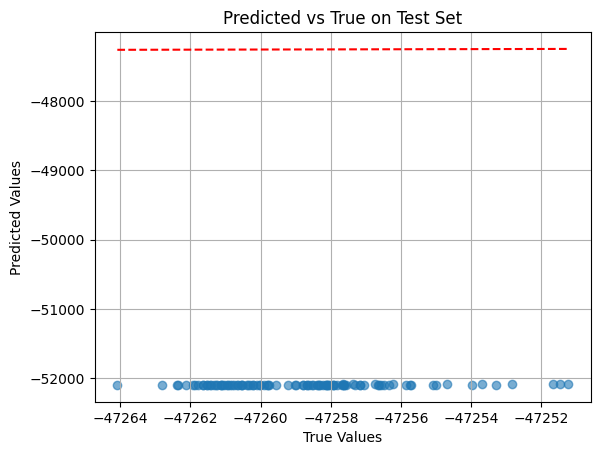

In [38]:
# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()


2. Evaluate on GNN model

In [30]:
# Create test dataset and loader
test_dataset = XYZGraphDataset(x_test_inv_test, y_test, threshold=2.0)
test_loader = DisjointLoader(test_dataset, epochs=1, batch_size=32, shuffle=False)

# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = gnn_model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 2.957205e-01
R²:  0.9836


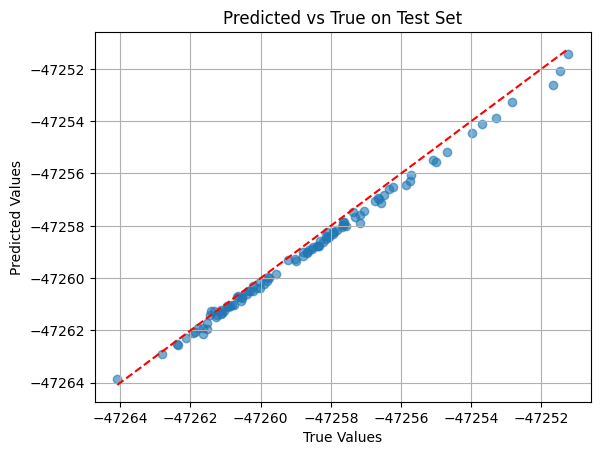

In [31]:
# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()
